In [1]:
import pandas as pd
import numpy as np
from utils import *
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data.csv')

In [3]:
def calError(row):
    if row['TOTAL'] == 0:
        val = 0
    else:
        val = (row['QTYERROR'] / row['TOTAL']) * 100
    return val

df['TOTAL'] =  df[['QTYERROR', 'QTYGOOD']].sum(axis=1)
df['ERROR_RATE'] = df.apply(calError, axis=1)
df.loc[:, ('WORKER')] = df['WORKER'].astype(str)
df.loc[:, ('WrkCtrID')] = df['WrkCtrID'].astype(str)
df['TIME_DEVIATION'] = df['CalcHours'] - df['Hours']

In [4]:
df.nunique()

ProdId            241
ITEMID             19
OprID              23
WORKER             15
WrkCtrID           34
CalcHours         282
Amount            245
Hours             221
QTYERROR            2
QTYGOOD            52
TOTAL              52
ERROR_RATE          5
TIME_DEVIATION    280
dtype: int64

In [5]:
df['ERROR_RATE'].unique()

array([  0.        ,  14.28571429,  16.66666667, 100.        ,
         5.88235294])

In [6]:
Counter(df['ERROR_RATE'])

Counter({0.0: 1091,
         14.285714285714285: 1,
         16.666666666666664: 2,
         100.0: 1,
         5.88235294117647: 1})

In [7]:
df.describe()

,CalcHours,Amount,Hours,QTYERROR,QTYGOOD,TOTAL,ERROR_RATE,TIME_DEVIATION
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,15.030301,81.919480,17.542772,0.004562,42.397810,42.402372,0.140056,-2.512471
std,54.245213,602.494361,111.283641,0.067419,243.659813,243.659148,3.136578,95.180171
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1623.903326
25%,0.666666,2.330000,0.360720,0.000000,0.000000,0.000000,0.000000,0.102345
50%,2.000000,6.670000,1.000000,0.000000,5.000000,5.000000,0.000000,0.684033
75%,8.000000,18.640000,4.000000,0.000000,18.000000,18.000000,0.000000,2.000000
max,600.000000,11120.000000,1869.236667,1.000000,3063.000000,3063.000000,100.000000,306.912600


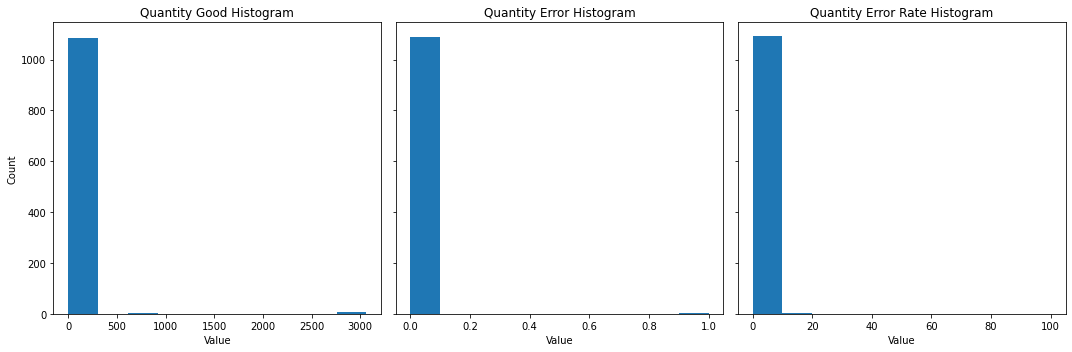

In [8]:
n_bins=10

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))
for i in range(3):
    axs[i].set_xlabel('Value')

axs[0].set_ylabel('Count')
axs[0].hist(df['QTYGOOD'], bins=n_bins)
axs[0].set_title('Quantity Good Histogram')
axs[1].hist(df['QTYERROR'], bins=n_bins)
axs[1].set_title('Quantity Error Histogram')
axs[2].hist(df['ERROR_RATE'], bins=n_bins)
axs[2].set_title('Quantity Error Rate Histogram')
plt.show()

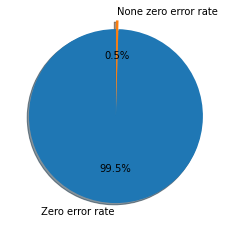

In [9]:
errorRateZero, errorRateNoneZero = 0, 0
for key, val in Counter(df['ERROR_RATE']).items():
    if key == 0:
        errorRateZero += val
    else:
        errorRateNoneZero += val

plt.pie([errorRateZero, errorRateNoneZero], labels=['Zero error rate', 'None zero error rate'], explode=[0,0.1], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

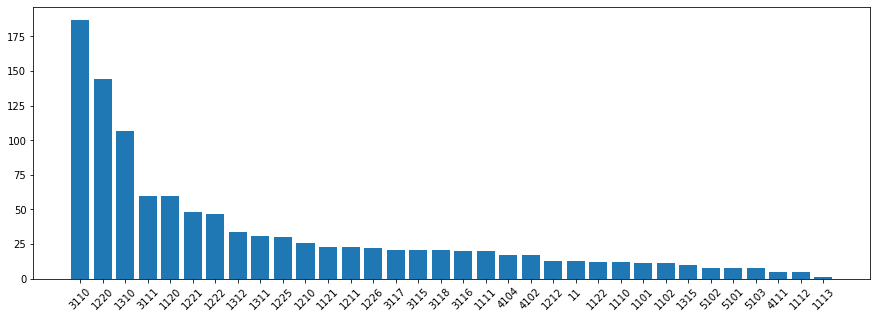

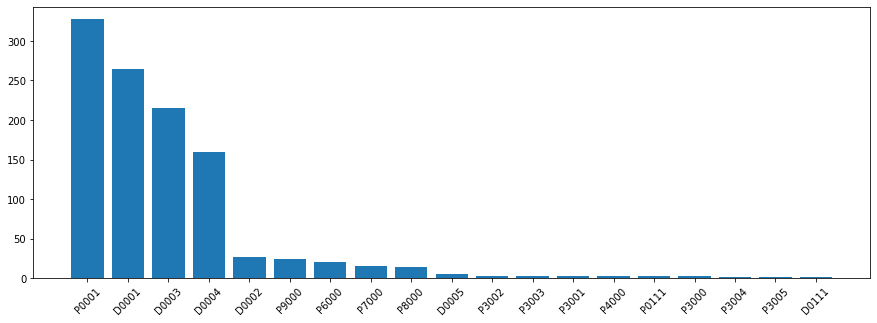

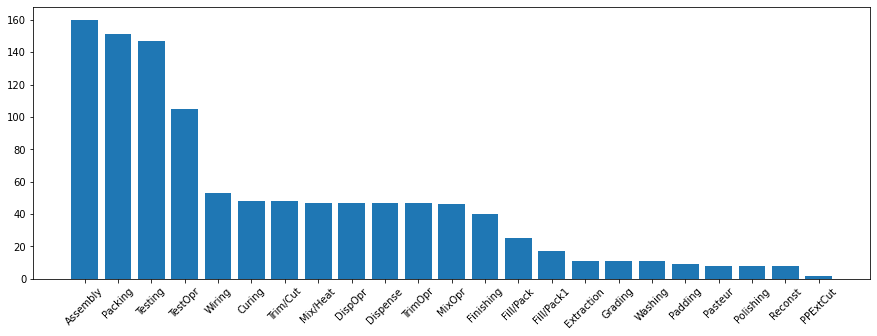

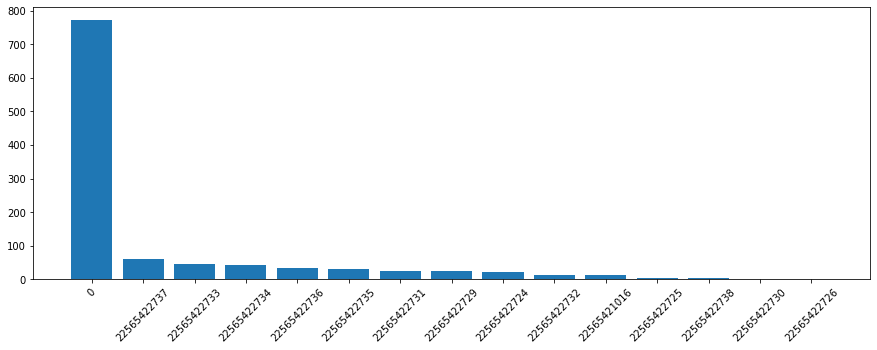

In [10]:
plotCategory(df, 'WrkCtrID')
plotCategory(df, 'ITEMID')
plotCategory(df, 'OprID')
plotCategory(df, 'WORKER')

# Preprocessing and feature engineering

In [11]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)
# X = data.to_numpy()
errorX = data.loc[:]
# y = df['ERROR_RATE'].astype(str)
data['ERROR_GROUP'] = np.where(df.ERROR_RATE > 0, True, False)
errorY = data['ERROR_GROUP'].astype(str)

In [12]:
errorSampleDict = getSampleDict(errorY)
maj = getMajorityClass(errorY)
classWeight = getClassWeight(errorY, maj)

In [13]:
pipeline = getResamplePipeline(errorSampleDict)
errorModel = RandomForestClassifier(random_state=42, class_weight=None)
errorX_res, errorY_res = pipeline.fit_resample(errorX, errorY)

# Training and validating

In [14]:
crossValidate(errorModel, errorX_res, errorY_res, 5, 3)

0.9804241690633442

In [15]:
errorX_train, errorX_test, errorY_train, errorY_test = train_test_split(errorX_res, errorY_res, random_state=0)
errorModel.fit(errorX_train, errorY_train)
print('Score for train data', errorModel.score(errorX_train, errorY_train))
print('Score for test data', errorModel.score(errorX_test, errorY_test))

Score for train data 0.9828641370869033
Score for test data 0.989010989010989


# Feature Importance

/Users/Mr_ren/DTU/thesis/utils.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


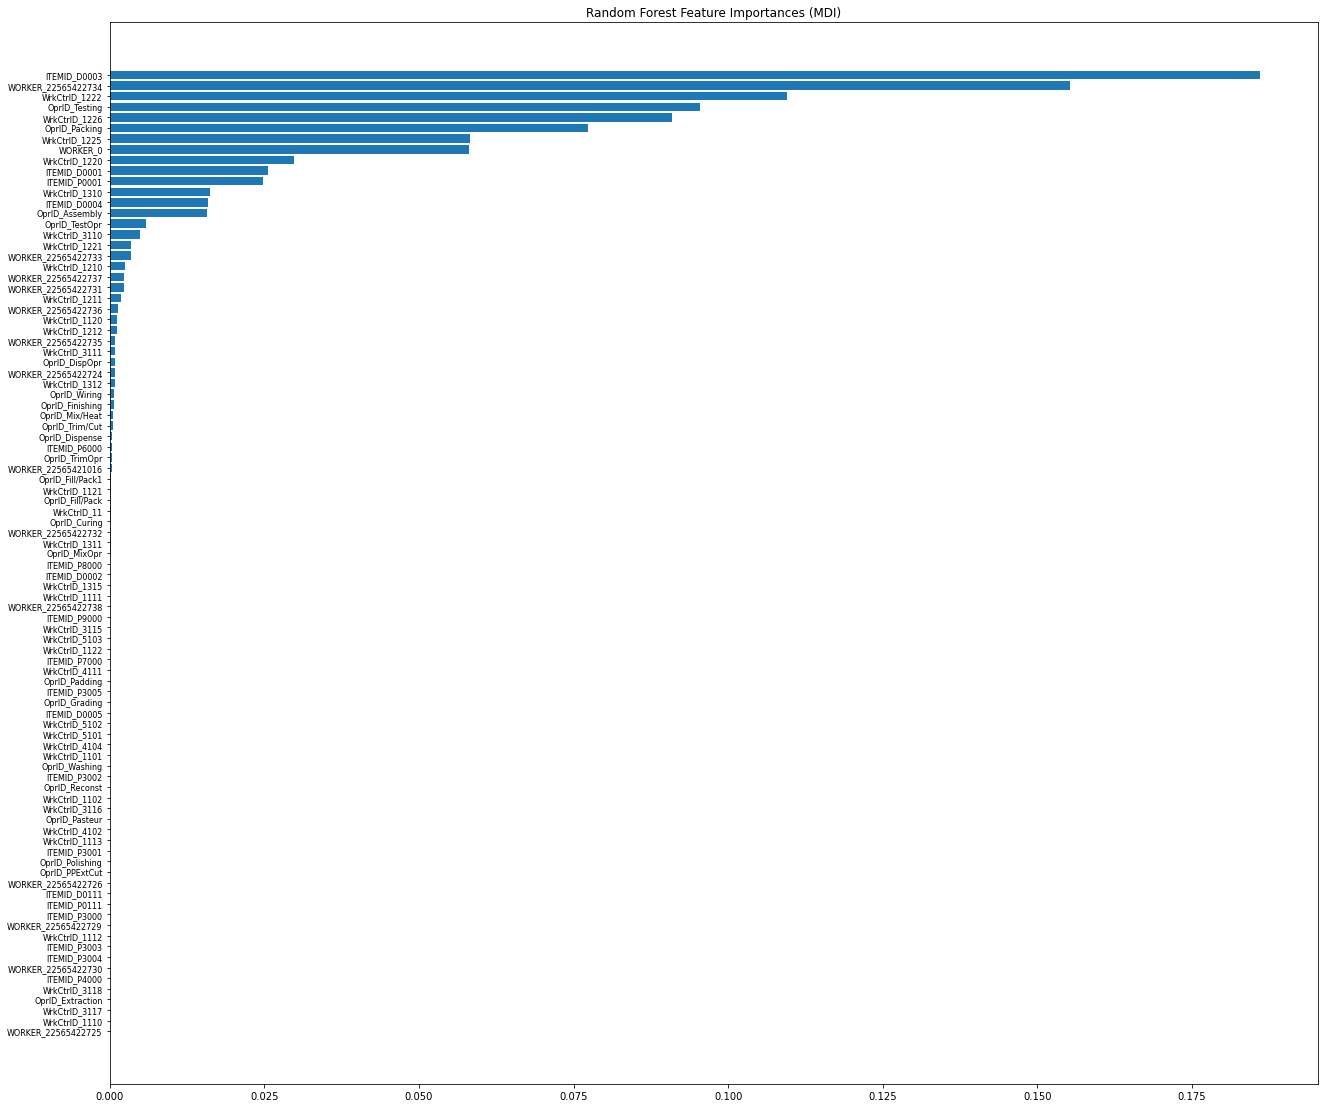

In [16]:
feature_names = pipeline.named_steps['encoding'].get_feature_names(list(errorX.columns))
randomForestFeatureImportancePlot(errorX_res, errorY_res, feature_names, errorModel)

## Permutation feature importance

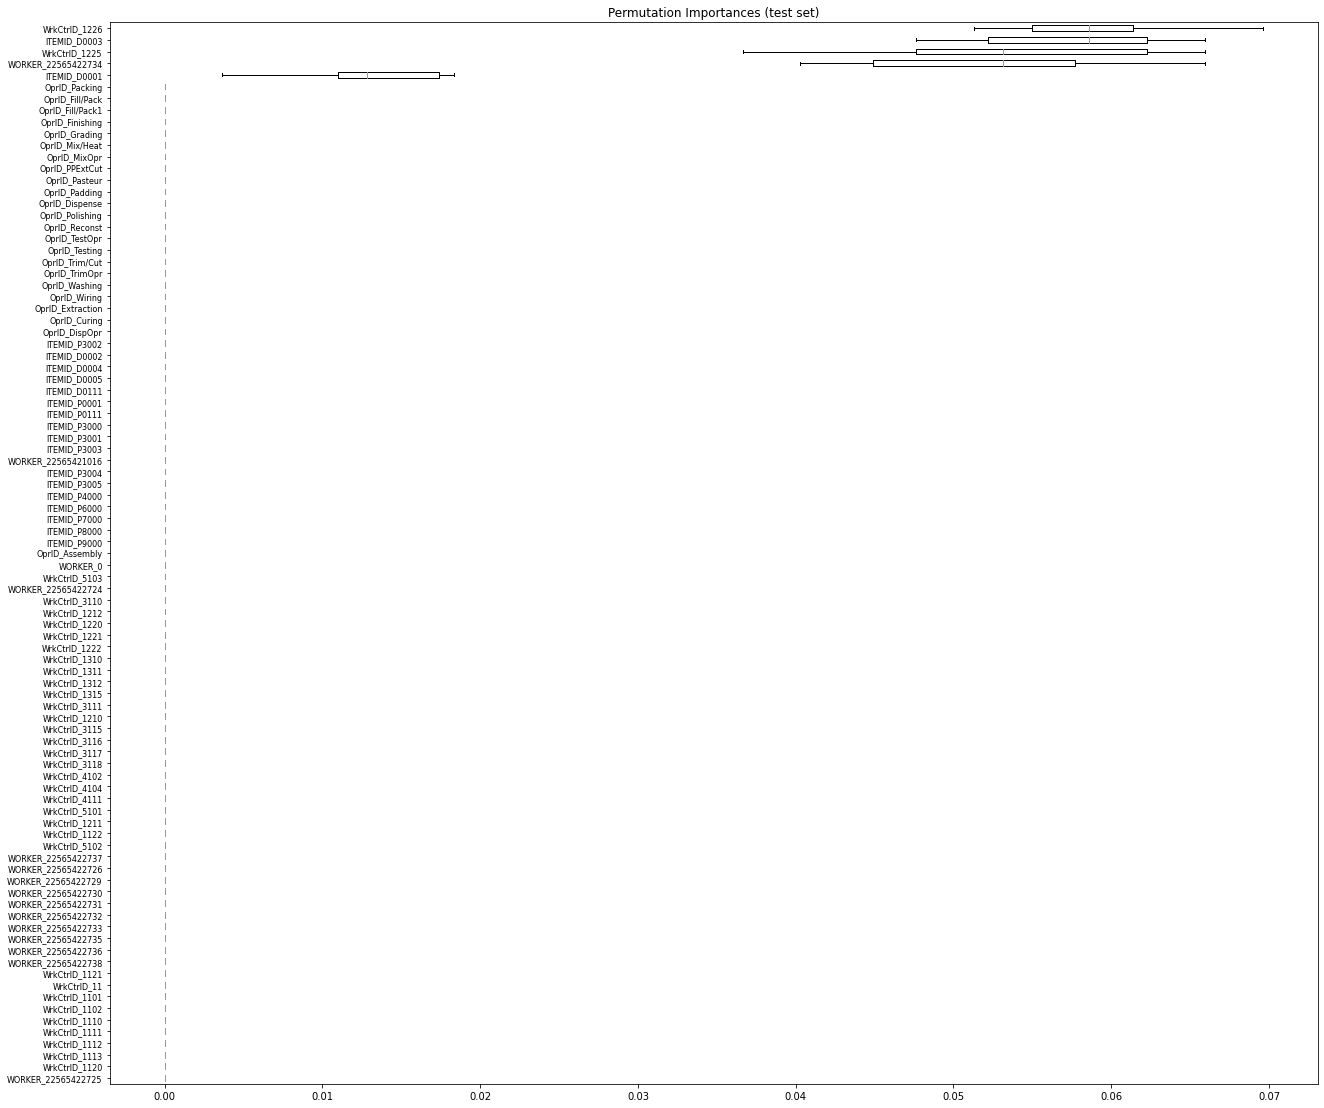

In [17]:
result = permuationFeatureImportancePlot(errorModel, errorX_test.todense(), errorY_test, feature_names)

## Multicollinear Features

In [18]:
# Select features that contribute to the model
sorted_idx = result.importances_mean.argsort()
errorX_res_df = pd.DataFrame(errorX_res.toarray(), columns=feature_names)
selected_features = feature_names[sorted_idx][-10:]
errorX_res_selected = errorX_res_df.loc[:, selected_features]

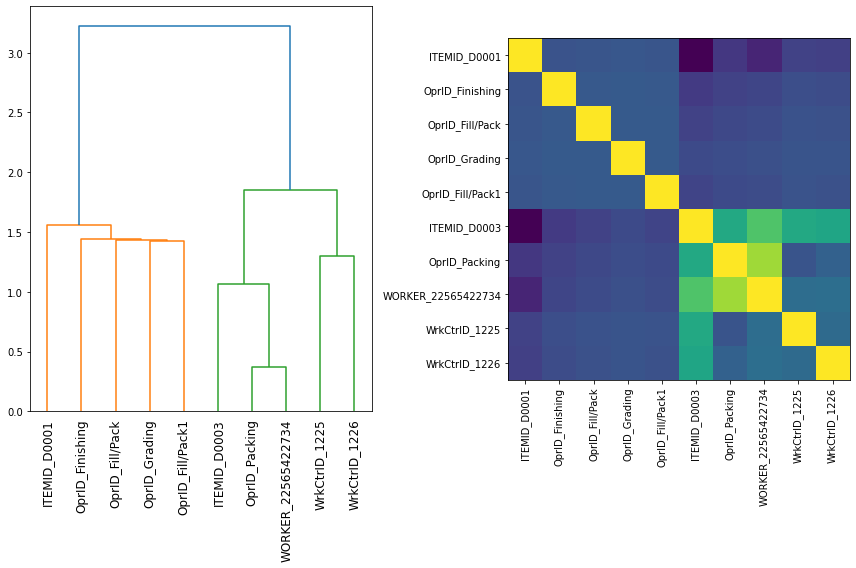

In [19]:
correlationPlot(errorX_res_selected, selected_features)

# Time Usage Deviation

In [20]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)

# timeY = clusterKDE(df['TIME_DEVIATION'])
timeY = clusterDBSCAN(df['TIME_DEVIATION'])
timeX = data.loc[:]

# Build Pipeline

In [32]:
maj = getMajorityClass(timeY)
classWeight = getClassWeight(timeY, maj, 2)
timeModel = svm.SVC(class_weight=classWeight)
# timeModel = RandomForestClassifier(random_state=42)
timeSampleDict = getSampleDict(timeY)
timePipeline = getResamplePipeline(timeSampleDict)
timeX_res, timeY_res = timePipeline.fit_resample(timeX, timeY)

# Validating

In [33]:
crossValidate(timeModel, timeX_res, timeY_res, 4, 3)

0.9316907218388878

In [34]:
timeX_train, timeX_test, timeY_train, timeY_test = train_test_split(timeX_res, timeY_res, random_state=0)
timeModel.fit(timeX_train, timeY_train)
print('Score for train data', timeModel.score(timeX_train, timeY_train))
print('Score for test data', timeModel.score(timeX_test, timeY_test))

Score for train data 0.9385210662080825
Score for test data 0.9317010309278351


# Feature Importance

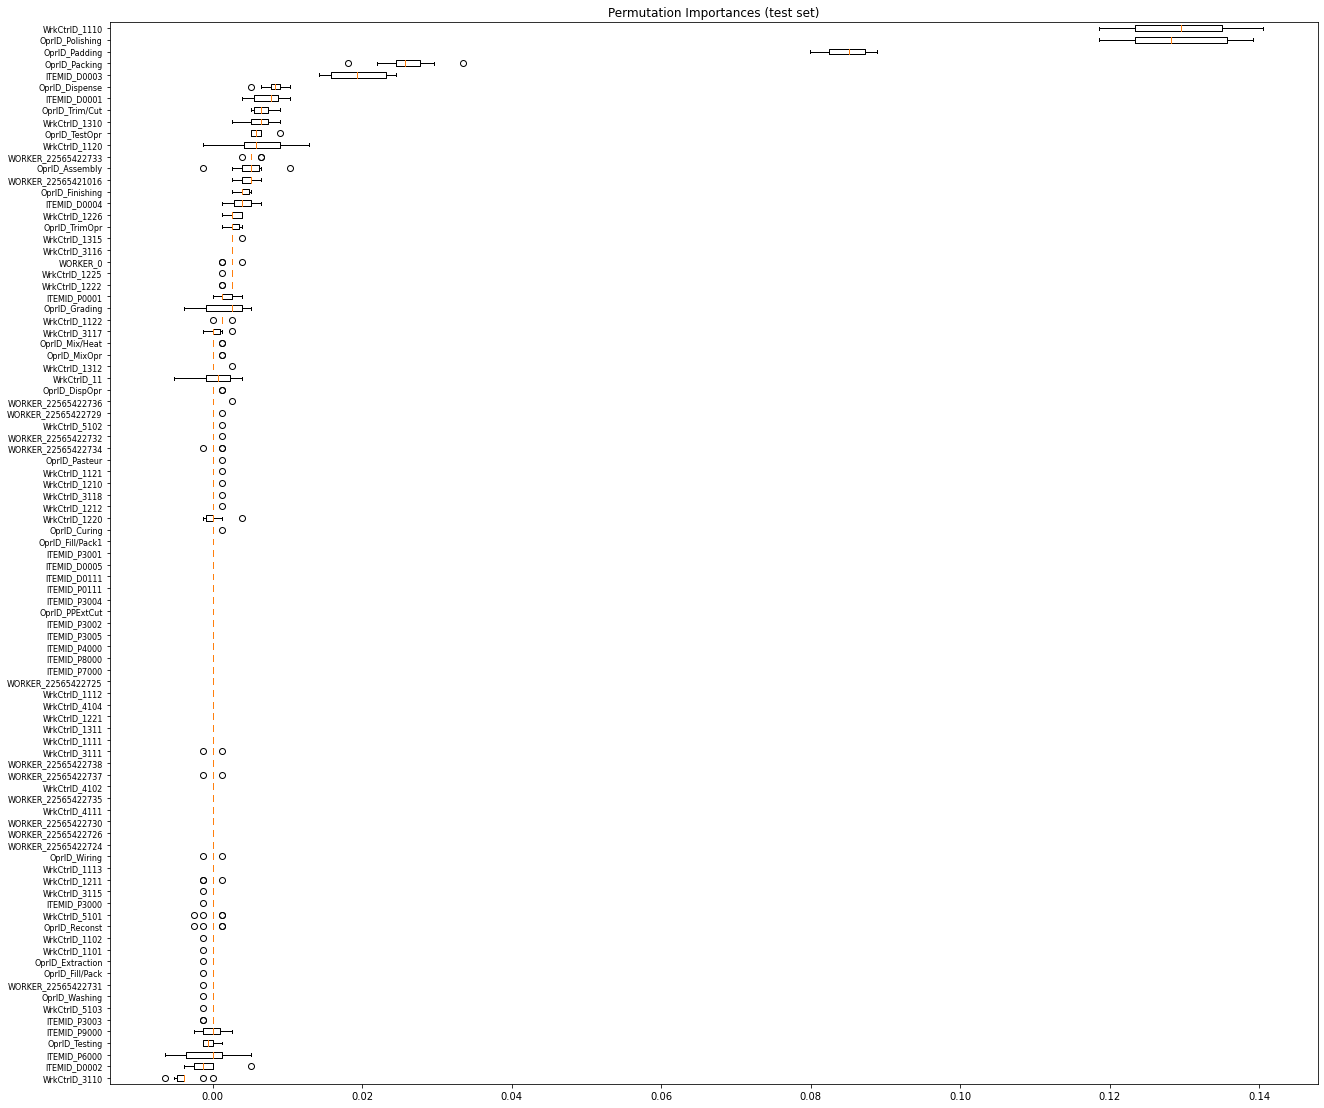

In [25]:
result = permuationFeatureImportancePlot(timeModel, timeX_test.todense(), timeY_test, feature_names)

# Feature Correlation 

In [26]:
sorted_idx = result.importances_mean.argsort()
timeX_res_df = pd.DataFrame(timeX_res.toarray(), columns=feature_names)
selected_features = feature_names[sorted_idx][-10:]
timeX_res_selected = timeX_res_df.loc[:, selected_features]

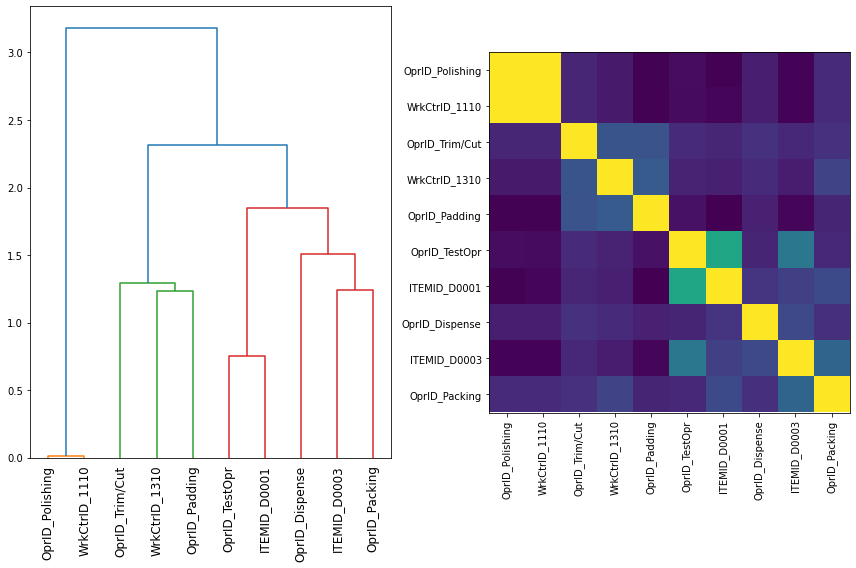

In [27]:
correlationPlot(timeX_res_selected, selected_features)

In [28]:
df.query('OprID == "Polishing"')

,ProdId,ITEMID,OprID,WORKER,WrkCtrID,CalcHours,Amount,Hours,QTYERROR,QTYGOOD,TOTAL,ERROR_RATE,TIME_DEVIATION
435,CNMF-000004,D0002,Polishing,22565421016,1121,27.866666,998.4,16.0,0.0,150.0,150.0,0.0,11.866666
438,P000001,D0002,Polishing,0,1110,600.000000,2400.0,300.0,0.0,200.0,200.0,0.0,300.000000
443,P000003,D0002,Polishing,0,1110,600.000000,2400.0,300.0,0.0,200.0,200.0,0.0,300.000000
446,P000004,D0002,Polishing,0,1110,600.000000,2400.0,300.0,0.0,200.0,200.0,0.0,300.000000
449,P000005,D0002,Polishing,0,1110,600.000000,2400.0,300.0,0.0,200.0,200.0,0.0,300.000000
452,P000006,D0002,Polishing,0,1110,600.000000,2400.0,300.0,0.0,200.0,200.0,0.0,300.000000
455,P000007,D0002,Polishing,0,1110,600.000000,2400.0,300.0,0.0,200.0,200.0,0.0,300.000000
458,P000008,D0002,Polishing,0,1110,240.000000,960.0,120.0,0.0,80.0,80.0,0.0,120.000000


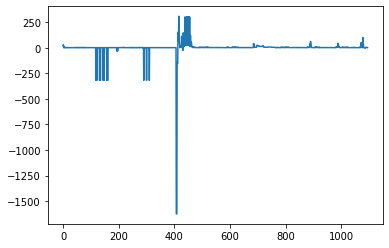

In [29]:
plt.plot(df['TIME_DEVIATION'])

In [30]:
df.query('ITEMID == "D0002" and OprID != "Polishing"')

,ProdId,ITEMID,OprID,WORKER,WrkCtrID,CalcHours,Amount,Hours,QTYERROR,QTYGOOD,TOTAL,ERROR_RATE,TIME_DEVIATION
423,CNMF-000001,D0002,Assembly,22565421016,1121,35.561666,1248.25,20.004,0.0,120.0,120.0,0.0,15.557666
433,CNMF-000004,D0002,Assembly,22565421016,1122,240.000000,11120.00,139.000,0.0,150.0,150.0,0.0,101.000000
434,CNMF-000004,D0002,Padding,22565421016,1211,120.000000,4492.80,72.000,0.0,150.0,150.0,0.0,48.000000
436,P000001,D0002,Assembly,0,1120,50.000000,195.00,25.000,0.0,200.0,200.0,0.0,25.000000
437,P000001,D0002,Padding,0,1120,100.000000,390.00,50.000,0.0,200.0,200.0,0.0,50.000000
439,P000002,D0002,Assembly,0,1120,50.000000,195.00,25.000,0.0,200.0,200.0,0.0,25.000000
440,P000002,D0002,Padding,0,1120,100.000000,390.00,50.000,0.0,200.0,200.0,0.0,50.000000
441,P000003,D0002,Assembly,0,1120,50.000000,195.00,25.000,0.0,200.0,200.0,0.0,25.000000
442,P000003,D0002,Padding,0,1120,100.000000,390.00,50.000,0.0,200.0,200.0,0.0,50.000000
444,P000004,D0002,Assembly,0,1120,50.000000,195.00,25.000,0.0,200.0,200.0,0.0,25.000000


In [31]:
sum_ = 0
for key, val in Counter(timeY).items():
    if key != 0:
        sum_ += val

(df.query('ITEMID == "D0002" and OprID != "Polishing"').shape[0] +df.query('OprID == "Polishing"').shape[0]) / sum_

0.4426229508196721